## Explore DFT relaxation space
- How much of the potential 15M battery structures have been relaxed so far?
- What does the coverage look like?

In [1]:
import os
os.chdir('../')
os.getcwd()

'/lustre/eaglefs/projects/rlmolecule/jlaw/crystal-gnn-fork/src'

In [2]:
import tensorflow as tf
import tensorflow_addons as tfa
import nfp
from nfp_extensions import RBFExpansion, CifPreprocessor
from tqdm.notebook import tqdm
from pymatgen.core import Structure
import pandas as pd
import numpy as np

from pymatgen.core import Composition

RDKit WARNING: [10:25:34] Enabling RDKit 2019.09.3 jupyter extensions


In [3]:
print(f'pandas version: {pd.__version__}')
print(f'numpy version: {np.__version__}')

pandas version: 1.1.4
numpy version: 1.21.0


In [5]:
import gzip
import json
def read_structures_file(structures_file):
    print(f"reading {structures_file}")
    with gzip.open(structures_file, 'r') as f:
        structures_dict = json.loads(f.read().decode())
    structures = {}
    for key, structure_dict in structures_dict.items():
        structures[key] = Structure.from_dict(structure_dict)
    print(f"\t{len(structures)} structures read")
    return structures

In [11]:
# first check to see how much of the crystal space is covered by the DFT relaxations
# make a stacked bar plot for composition types separated by two colors
gnn_dir = "/projects/rlmolecule/jlaw/crystal-gnn-fork/"
df_dft = pd.read_csv(f"{gnn_dir}/inputs/structures/battery_relaxed_energies.csv")
df_dft.head(2)

,comp_type,composition,id,energyperatom
0,112,Mg2Cl1P1,Mg2Cl1P1_sg2_icsd_035676_1,-3.527097
1,112,Mg2Cl1P1,Mg2Cl1P1_sg55_icsd_642437_1,-3.365935


In [7]:
decorations = pd.read_csv("/projects/rlmolecule/jlaw/crystals/2021-09-22/all-decorations-c150.txt.gz", 
                          header=None,
                          squeeze=True)
decorations.head(3)

0     K3P1|_1_3|monoclinic|POSCAR_sg9_icsd_261955|1
1    K3P1|_1_3|monoclinic|POSCAR_sg15_icsd_010490|1
2    K3P1|_1_3|monoclinic|POSCAR_sg15_icsd_039430|1
Name: 0, dtype: object

In [8]:
def extract_id(x):
    """
    Example rlmolecule ID: K3P1|_1_3|monoclinic|POSCAR_sg9_icsd_261955|1
    dft relaxation ID: K3P1_sg9_icsd_261955_1
    """
    split = x.split("|")
    return f"{split[0]}_{split[3].replace('POSCAR_','')}_{split[4]}"
# decorations['id'] = 
decors2 = decorations.apply(extract_id)
decors2.head(2)

0     K3P1_sg9_icsd_261955_1
1    K3P1_sg15_icsd_010490_1
Name: 0, dtype: object

In [9]:
df2 = pd.DataFrame({'id': decors2, 'state': decorations})
df2['comp_type'] = df2['state'].apply(lambda x: x.split('|')[1].replace('_',''))
df2['composition'] = df2['state'].apply(lambda x: x.split('|')[0])
df2['relaxation'] = 'unrelaxed'
df2 = df2.drop('state', 1)
df2 = df2.set_index('id')
df2.head()

,comp_type,composition,relaxation
id,,,
K3P1_sg9_icsd_261955_1,13,K3P1,unrelaxed
K3P1_sg15_icsd_010490_1,13,K3P1,unrelaxed
K3P1_sg15_icsd_039430_1,13,K3P1,unrelaxed
K3P1_sg12_icsd_096543_1,13,K3P1,unrelaxed
K3P1_sg4_icsd_043243_1,13,K3P1,unrelaxed


In [12]:
df_dft['relaxation'] = 'relaxed'
df_dft = df_dft.set_index('id')
df_dft.head(2)

,comp_type,composition,energyperatom,relaxation
id,,,,
Mg2Cl1P1_sg2_icsd_035676_1,112,Mg2Cl1P1,-3.527097,relaxed
Mg2Cl1P1_sg55_icsd_642437_1,112,Mg2Cl1P1,-3.365935,relaxed


In [13]:
df2['relaxation'] = df_dft['relaxation']
df2['relaxation'] = df2['relaxation'].fillna('unrelaxed')
df2['relaxation'].value_counts()

unrelaxed    14910310
relaxed         67840
Name: relaxation, dtype: int64

In [14]:
comps = set(df2['composition'].unique())
relaxed_comps = set(df_dft['composition'].unique())
print(f"{len(relaxed_comps)} / {len(comps)} compositions have a relaxed structure")

772 / 138776 compositions have a relaxed structure


In [15]:
df_dft['composition'].value_counts()

Mg1Hf1P1Cl1O5    406
Mg1Ti1W1O5S1     397
Mg1Hf1O3         372
Mg3N1P1          372
Mg1Ti1O3         371
                ... 
Na3Sn2I2N3         2
K2Hg2F3Cl3         2
K2Y1Ti1Br3O3       1
Zn2Si2Cl3N3        1
Na1La1B2Br4N2      1
Name: composition, Length: 772, dtype: int64

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
df_plot = df2.groupby(['comp_type', 'relaxation']).size().reset_index().pivot(columns='relaxation', index='comp_type', values=0)
df_plot.head(2)

relaxation,relaxed,unrelaxed
comp_type,,
11,3294.0,2882.0
111,NaN,21780.0


In [18]:
df_plot.fillna(0, inplace=True)
df_plot['sum'] = df_plot['relaxed'] + df_plot['unrelaxed']
df_plot['frac'] = df_plot['relaxed'] / df_plot['sum']
df_plot = df_plot.sort_values(['frac', 'sum'], ascending=False)
df_plot.drop(['sum', 'frac'], 1, inplace=True)

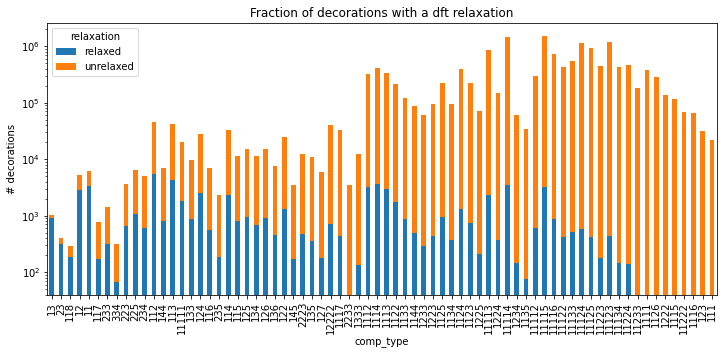

In [21]:
f, ax = plt.subplots(figsize=(12,5))
ax = df_plot.plot.bar(stacked=True, ax=ax)
ax.set_yscale('log')
ax.set_ylabel("# decorations")
ax.set_title("Fraction of decorations with a dft relaxation")
plt.show()
plt.close()

In [22]:
comps = set(df2['composition'].unique())
relaxed_comps = set(df_dft['composition'].unique())
print(f"{len(relaxed_comps)} / {len(comps)} compositions have a relaxed structure")

772 / 138776 compositions have a relaxed structure


In [23]:
df2.head(1)

,comp_type,composition,relaxation
id,,,
K3P1_sg9_icsd_261955_1,13,K3P1,unrelaxed


In [24]:
from collections import defaultdict
import re

In [25]:
def get_eles_from_comp(comp: str):
    # split by the digits
    # e.g., for "Li1Sc1F4": ['Li', '1', 'Sc', '1', 'F', '4', '']
    split = np.asarray(re.split('(\d+)', comp))
    eles = tuple(split[range(0, len(split) - 1, 2)])
    return eles

In [26]:
# also make the same type of plot but for individual elements
ele_count_rel = defaultdict(int)
ele_count_unrel = defaultdict(int)

for comp, rel in tqdm(df2[['composition', 'relaxation']].values):
    eles = get_eles_from_comp(comp)
    for e in eles:
        if rel == "unrelaxed":
            ele_count_unrel[e] += 1
        else:
            ele_count_rel[e] += 1

  0%|          | 0/14978150 [00:00<?, ?it/s]

In [27]:
df_e = pd.DataFrame({'relaxed': ele_count_rel, 'unrelaxed': ele_count_unrel})
df_e

,relaxed,unrelaxed
K,11819,3365005
P,15639,4550638
B,4005,1776461
F,10103,3093769
Y,5099,1775367
W,3604,989282
Ti,4805,1410701
Cd,7185,2188532
Sn,4302,1411204
Hg,6076,2189641


In [28]:
# df_e['sum'] = df_e['relaxed'] + df_e['unrelaxed']
# df_e['frac'] = df_e['relaxed'] / df_e['sum']
df_e = df_e.sort_values('relaxed', ascending=False)
# df_e.drop(['sum', 'frac'], 1, inplace=True)

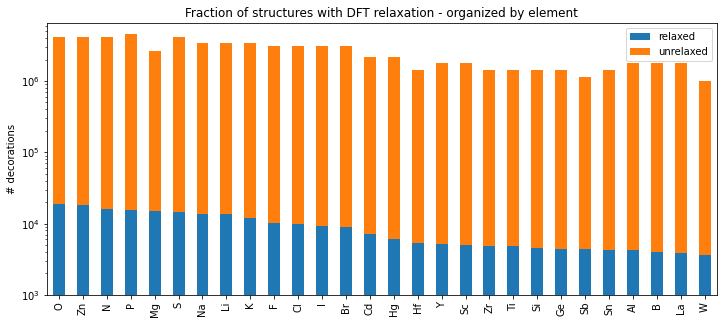

In [31]:
f, ax = plt.subplots(figsize=(12,5))
ax = df_e.plot.bar(stacked=True, ax=ax)
ax.set_yscale('log')
ax.set_ylim(1000, ax.get_ylim()[1])
ax.set_ylabel("# decorations")
ax.set_title("Fraction of structures with DFT relaxation - organized by element")
plt.show()

### Generate predicted energies for all battery structures

- Check to see if there's any anomalies in the predicted energies for the battery structures
- This work was moved to `examples/crystal_energy/scripts/all_crystal_pred_energy.py`

In [11]:
def generate_decoration(state: CrystalState) -> Structure:
    # Create the decoration of this composition onto this prototype structure
    # the 'action_node' string has the following format at this point:
    # comp_type|prototype_structure|decoration_idx
    # we just need 'comp_type|prototype_structure' to get the icsd structure
    structure_key = '|'.join(state.action_node.split('|')[:-1])
    icsd_prototype = structures[structure_key]
    decoration_idx = int(state.action_node.split('|')[-1]) - 1
    decorated_structure, stoich = CrystalState.decorate_prototype_structure(
        icsd_prototype, state.composition, decoration_idx=decoration_idx)
#     # use this function to get just the composition of the decoration
#     comp = decorate_prototype_structure_comp_only(
#         icsd_prototype, state.composition, decoration_idx=decoration_idx)
    return decorated_structure

In [16]:
def generate_decorations(builder, state, visited, progress_bar):
    """ DFS to generate all decorations (state string only) from the ICSD prototype structures
    """
    if str(state) in visited:
        return
    children = state.get_next_actions(builder)
    for c in children:
        yield from generate_decorations(builder, c, visited, progress_bar)
        visited.add(str(c))

    if len(children) == 0:
        progress_bar.update(1)
        
        # generate the decorated structure
        try:
            decorated_structure = generate_decoration(state)
        except AssertionError:
            return
        yield decorated_structure

In [19]:
preprocessor = CrystalPreprocessor()
builder = CrystalBuilder()

root = 'root'
state = CrystalState(root)

n = 16*10**6
progress_bar = tqdm(total=n)
visited = set()
decorations = list(generate_decorations(builder, state, visited, progress_bar))
print(len(decorations))

  0%|          | 0/16000000 [00:00<?, ?it/s]

  0%|          | 89/16000000 [01:17<3872:41:32,  1.15it/s]

  0%|          | 3143/16000000 [00:29<22:11:31, 200.23it/s]

KeyboardInterrupt: 

In [4]:
# Initialize the preprocessor class
preprocessor = CifPreprocessor(num_neighbors=12)
preprocessor.from_json('preprocessor.json')

# Load the model trained on "cubic lattices"
model_file = "inputs/models/icsd_battery_unrelaxed/hypo_randsub0_05_icsd_randsub0_05_seed1/best_model.hdf5"
model = tf.keras.models.load_model(
    model_file,
    custom_objects={**nfp.custom_objects, **{'RBFExpansion': RBFExpansion}})

# generate the battery structures

test_dataset = tf.data.Dataset.from_generator(
    lambda: (preprocessor.construct_feature_matrices(get_crystal(id), train=False)
             for id in tqdm(test.id)),
    output_types=preprocessor.output_types,
    output_shapes=preprocessor.output_shapes)\
    .padded_batch(batch_size=32,
                  padded_shapes=preprocessor.padded_shapes(max_sites=256, max_bonds=2048),
                  padding_values=preprocessor.padding_values)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
